This notebook is for PCA operations on the original Wildfire dataset

# Import Lib

In [1]:
import dataset
from tensorflow import estimator as tf_estimator
import models.losses as losses
import tensorflow as tf
from models.metrics import *
import models.cnn_autoencoder_model as cnnmodel
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.decomposition import PCA
import xgboost as xgb

# Load Dataset

In [2]:
hparams = {
    # 数据路径
    'train_path': '../dataset/next_day_wildfire_spread_train*',
    'eval_path': '../dataset/next_day_wildfire_spread_eval*',
    'test_path': '../dataset/next_day_wildfire_spread_test*',
    
    # 特征
    'input_features': ['elevation', 'pdsi', 'NDVI', 'pr', 'sph', 'th', 'tmmn',
                  'tmmx', 'vs', 'erc', 'population', 'PrevFireMask'],
    'output_features': ['FireMask'],
    
    # 方位通道
    'azimuth_in_channel': None,
    'azimuth_out_channel': None,
    
    # 数据和模型参数
    'data_sample_size': 64,
    'sample_size': 32,
    'output_sample_size': 32,
    'batch_size': 128,
    'shuffle': False,
    'shuffle_buffer_size': 10000,
    'compression_type': None,
    'input_sequence_length': 1,
    'output_sequence_length': 1,
    'repeat': False,
    'clip_and_normalize': True,
    'clip_and_rescale': False,
    
    # 数据增强
    'random_flip': False,
    'random_rotate': False,
    'random_crop': False,
    'center_crop': True,
    
    # 其他参数
    'downsample_threshold': 0.0,
    'binarize_output': True
}

train_dataset = dataset.make_dataset(
    hparams,
    mode = tf_estimator.ModeKeys.TRAIN
)
val_dataset = dataset.make_dataset(
    hparams,
    mode = tf_estimator.ModeKeys.EVAL
)
test_dataset = dataset.make_dataset(
    hparams,
    mode = tf_estimator.ModeKeys.PREDICT
)

In [3]:
def dataset_to_numpy(dataset):
    features_list = []
    labels_list = []
    for features, label in dataset:
        features_list.append(features.numpy())  # 提取特征并转换为 NumPy 数组
        labels_list.append(label.numpy())       # 提取标签并转换为 NumPy 数组
    return np.vstack(features_list), np.concatenate(labels_list)

# 转换数据集
train_x, train_y = dataset_to_numpy(train_dataset)
val_x, val_y = dataset_to_numpy(val_dataset)
test_x, test_y = dataset_to_numpy(test_dataset)

train_y[train_y == -1] = 0
val_y[val_y == -1] = 0
test_y[test_y == -1] = 0

In [4]:
train_x.reshape(train_x.shape[0], -1).shape

(14979, 12288)

# PCA

In [6]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
)

In [8]:
train_y_flat = train_y.reshape(train_y.shape[0], -1)
val_y_flat = val_y.reshape(val_y.shape[0], -1)
test_y_flat = test_y.reshape(test_y.shape[0], -1)

input_tensor = tf.keras.layers.Input((32, 32, 12))
num_out_channels = 1
encoder_layers = [16,32]
decoder_layers = [32,16]
encoder_pools = [2,2]
decoder_pools = [2,2]
autoencoder_model = cnnmodel.create_model(
    input_tensor,
    num_out_channels,
    encoder_layers,
    decoder_layers,
    encoder_pools,
    decoder_pools,
)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder_model.compile(optimizer=optimizer,
              loss=losses.weighted_cross_entropy_with_logits_with_masked_class(pos_weight=2),
              metrics=[AUCWithMaskedClass(with_logits=True)])
history = autoencoder_model.fit(train_x, train_y_flat, epochs=100, validation_data=(val_x, val_y_flat), callbacks=[early_stopping])

Epoch 1/100
469/469 [==============================] - 49s 17ms/step - loss: 0.1848 - auc_with_masked_class: 0.2054 - val_loss: 0.2060 - val_auc_with_masked_class: 0.2172
Epoch 2/100
469/469 [==============================] - 7s 15ms/step - loss: 0.1483 - auc_with_masked_class: 0.3102 - val_loss: 0.1866 - val_auc_with_masked_class: 0.2626
Epoch 3/100
469/469 [==============================] - 7s 15ms/step - loss: 0.1415 - auc_with_masked_class: 0.3392 - val_loss: 0.1870 - val_auc_with_masked_class: 0.2803
Epoch 4/100
469/469 [==============================] - 7s 15ms/step - loss: 0.1375 - auc_with_masked_class: 0.3575 - val_loss: 0.2076 - val_auc_with_masked_class: 0.2626
Epoch 5/100
469/469 [==============================] - 7s 15ms/step - loss: 0.1350 - auc_with_masked_class: 0.3709 - val_loss: 0.1902 - val_auc_with_masked_class: 0.2874
Epoch 6/100
469/469 [==============================] - 7s 15ms/step - loss: 0.1325 - auc_with_masked_class: 0.3813 - val_loss: 0.1987 - val_auc_with_

In [9]:

# 预测
predictions = autoencoder_model.predict(test_x)

# 输出预测结果
print(predictions.shape)

53/53 [==============================] - 0s 6ms/step
(1689, 1024)


In [10]:
test_y_flat = test_y.reshape(test_y.shape[0], -1)

mask = test_y_flat != -1

# 应用掩码
masked_labels = test_y_flat[mask]
masked_predictions = predictions[mask]

# 计算 AUC
auc_metric = tf.keras.metrics.AUC(curve='PR')
auc_metric.update_state(masked_labels, masked_predictions)
auc = auc_metric.result().numpy()

print("AUC with masked class: %.2f" % auc)

AUC with masked class: 0.19


# SHAP

In [15]:
import shap
import gc

explainer = shap.GradientExplainer(unet_model, train_x[:1])
num_samples = test_x.shape[0]
batch_size = 50
all_shap_values = []
all_reduced_average_shap_values = []

for start_idx in range(0, num_samples, 50):
    
    end_idx = min(start_idx + batch_size, num_samples)

    print(f"Processing sample {start_idx} to {end_idx}")
    
    batch_shap_values = explainer.shap_values(test_x[start_idx:end_idx])

    # 计算平均值
    average_shap_values = np.sum(batch_shap_values, axis=0)
    reduced_average_shap_values = np.mean(average_shap_values, axis=(1, 2))
    np.save(f'./unet_average_shap_{start_idx}.npy', reduced_average_shap_values)

    # 将结果添加到列表中
    all_reduced_average_shap_values.append(reduced_average_shap_values)

    # 释放内存
    del batch_shap_values
    del reduced_average_shap_values

# final_shap_values = np.concatenate(all_shap_values, axis=1)
final_reduced_sum_shap_values = np.concatenate(all_reduced_average_shap_values, axis=0)
# final_average_shap_values = np.mean(all_average_shap_values, axis=0)

shap.initjs()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Processing sample 0 to 50


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Processing sample 50 to 100
Processing sample 100 to 150
Processing sample 150 to 200
Processing sample 200 to 250
Processing sample 250 to 300
Processing sample 300 to 350
Processing sample 350 to 400
Processing sample 400 to 450
Processing sample 450 to 500
Processing sample 500 to 550
Processing sample 550 to 600
Processing sample 600 to 650
Processing sample 650 to 700


In [ ]:
TITLES = [
  'Elevation',
  'Wind direction',
  'Wind velocity',
  'Min temp',
  'Max temp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population density',
  'Energy release component',
  'Previous fire mask',
]

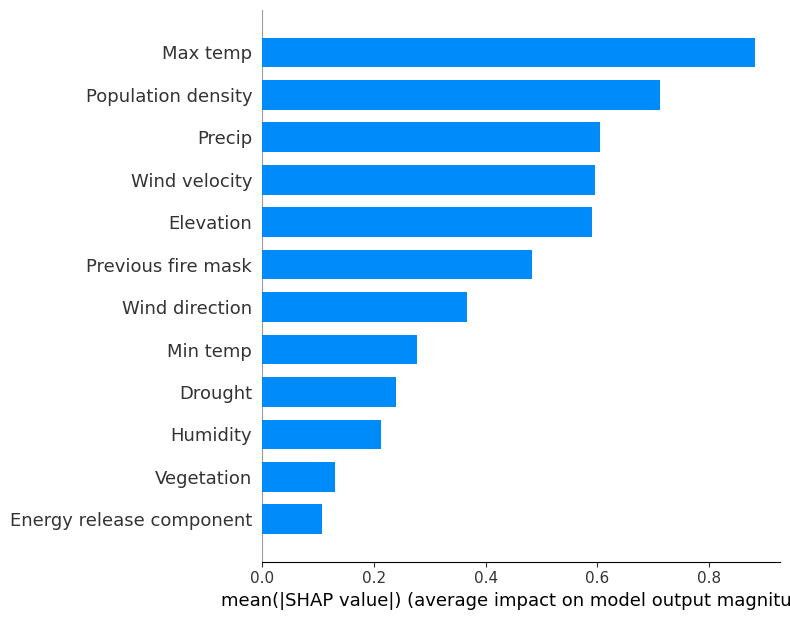

In [ ]:
shap.summary_plot(final_reduced_sum_shap_values, feature_names=TITLES, plot_type='bar')